# FEATURES



In [1]:
# libraries
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio
import torch

from nilearn import plotting

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

## **Load Data**

In [2]:
# load data
main_dir = './data_favour/FC_Matrices/'
file_names = sorted(os.listdir(main_dir))
file_names

['resultsROI_Condition001.mat',
 'resultsROI_Subject001_Condition001.mat',
 'resultsROI_Subject002_Condition001.mat',
 'resultsROI_Subject003_Condition001.mat',
 'resultsROI_Subject004_Condition001.mat',
 'resultsROI_Subject005_Condition001.mat',
 'resultsROI_Subject006_Condition001.mat',
 'resultsROI_Subject007_Condition001.mat',
 'resultsROI_Subject008_Condition001.mat',
 'resultsROI_Subject009_Condition001.mat',
 'resultsROI_Subject010_Condition001.mat',
 'resultsROI_Subject011_Condition001.mat',
 'resultsROI_Subject012_Condition001.mat',
 'resultsROI_Subject013_Condition001.mat',
 'resultsROI_Subject014_Condition001.mat',
 'resultsROI_Subject015_Condition001.mat',
 'resultsROI_Subject016_Condition001.mat',
 'resultsROI_Subject017_Condition001.mat',
 'resultsROI_Subject018_Condition001.mat',
 'resultsROI_Subject019_Condition001.mat',
 'resultsROI_Subject020_Condition001.mat',
 'resultsROI_Subject021_Condition001.mat',
 'resultsROI_Subject022_Condition001.mat',
 'resultsROI_Subject02

In [3]:
'''
@DOF: (35,) Degree of freedom for each subject
@SE: (35, 167) ...for each subject, per column
@Z: Z-scores?? for each subject, same dim as FC scores
@names: (1, 165) row labels
@names2: (1, 167) column labels
@regressors: (1, 1) ...all data?
@xyz: (1, 167) ...nodes/positions for each FC matrix column (across all subjects)
'''
fc_results = sio.loadmat(f'{main_dir}resultsROI_Condition001.mat')

In [4]:
fc_results.keys()

dict_keys(['__header__', '__version__', '__globals__', 'names', 'xyz', 'Z', 'DOF', 'names2', 'SE', 'regressors'])

In [5]:
# Read in Functional Connectivity matrices
fc_dataset = []

for f in file_names[1:]:
  fc_matrix = sio.loadmat(f'{main_dir}{f}')

  # df = pd.DataFrame(fc_matrix['Z'], fc_results['names'], fc_results['names2'])
  fc_dataset.append(fc_matrix['Z'][:, :165])

fc_dataset = np.asarray(fc_dataset)

In [6]:
# Stack FC Matrices (35*165=5775 rows x 167 columns)
fc_dfs = []
index = [f[0] for f in fc_results['names'][0]]
columns = [f[0] for f in fc_results['names2'][0][:-2]]

for matrix in fc_dataset:
    df = pd.DataFrame(matrix)
    df.index = index
    df.columns = columns
    fc_dfs.append(df)

fc_dfs_stacked = pd.concat(fc_dfs)

In [7]:
# Note number of ROIs and networks being used
roi_coords = fc_results['xyz'][0][:-2] # extract xyz coordinates for each ROI
roi_coords = np.array([coords[0] for coords in roi_coords]) # reshape coords
roi_networks = columns
n_regions = len(roi_coords)
print(f'MSDL has {n_regions} ROIs, part of the following networks : \n {roi_networks}.')

MSDL has 165 ROIs, part of the following networks : 
 ['networks.DefaultMode.MPFC (1,55,-3)', 'networks.DefaultMode.LP (L) (-39,-77,33)', 'networks.DefaultMode.LP (R) (47,-67,29)', 'networks.DefaultMode.PCC (1,-61,38)', 'networks.SensoriMotor.Lateral (L) (-55,-12,29)', 'networks.SensoriMotor.Lateral (R) (56,-10,29)', 'networks.SensoriMotor.Superior  (0,-31,67)', 'networks.Visual.Medial (2,-79,12)', 'networks.Visual.Occipital (0,-93,-4)', 'networks.Visual.Lateral (L) (-37,-79,10)', 'networks.Visual.Lateral (R) (38,-72,13)', 'networks.Salience.ACC (0,22,35)', 'networks.Salience.AInsula (L) (-44,13,1)', 'networks.Salience.AInsula (R) (47,14,0)', 'networks.Salience.RPFC (L) (-32,45,27)', 'networks.Salience.RPFC (R) (32,46,27)', 'networks.Salience.SMG (L) (-60,-39,31)', 'networks.Salience.SMG (R) (62,-35,32)', 'networks.DorsalAttention.FEF (L)  (-27,-9,64)', 'networks.DorsalAttention.FEF (R)  (30,-6,64)', 'networks.DorsalAttention.IPS (L)  (-39,-43,52)', 'networks.DorsalAttention.IPS (R)  (

In [8]:
## ROI COORDS
roi_coords_df = pd.DataFrame(roi_coords.T, columns=columns, index=['x', 'y', 'z'])
roi_coords_df

from pathlib import Path
filepath = Path('./Data/Network/roi_coords.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
roi_coords_df.to_csv(filepath)

In [9]:
# Adding subjects to dataset
n_subjects = fc_dataset.shape[0]
n_features_rows = fc_dataset.shape[1]
n_features_cols = fc_dataset.shape[2]

'''
Recursive function to create a subject ID from a string of the subject number
'''
def strings_in_a_list(n, s):
    if n == 0:
        return []
    else:
        l = strings_in_a_list(n - 1, s)
        l.append(s)
        return l

subject_labels = ['Subject %d' % (i+1000) for i in range(1, len(fc_dataset)+1)]
subject_idcs = []
for p in subject_labels:
  tmp = strings_in_a_list(n_features_rows, p)
  subject_idcs.append(tmp)

# Get indices of subject IDs and features for multi-index stacking
print(len(subject_idcs))
subject_idcs = np.array(subject_idcs).flatten() # n_features(165) x n_subjects(35)
ftrs_idcs = fc_dfs_stacked.index.values.tolist() # n_features(165) x n_subjects(35)
subject_idcs.shape

35


(5775,)

In [10]:
# Multindex view of data (35*165=5775 rows x 167 columns) by 35 subjects
multi_fc_df = pd.DataFrame(fc_dfs_stacked.values,
                  index=[subject_idcs, ftrs_idcs],
                  columns=fc_dfs_stacked.columns)

multi_fc_df = multi_fc_df.astype('float') # set dtype of every column to float

In [11]:
multi_fc_df.head()

networks.DefaultMode.MPFC (1,55,-3)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                             NaN   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.716286   
             networks.DefaultMode.LP (R) (47,-67,29)                                    0.807761   
             networks.DefaultMode.PCC (1,-61,38)                                        0.613360   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                            -0.506295   

                                                             networks.DefaultMode.LP (L) (-39,-77,33)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                             0.716286   
             networks.DefaultMode.LP (L) (-39,-77,33)                                             NaN   
             networks.DefaultMode.LP (R) (47,-67,29)                                         1.223718   
             networks.DefaultMode.PCC (1,-61,38)                                             0.951083   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                 -0.406710   

                                                             networks.DefaultMode.LP (R) (47,-67,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                            0.807761   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       1.223718   
             networks.DefaultMode.LP (R) (47,-67,29)                                             NaN   
             networks.DefaultMode.PCC (1,-61,38)                                            0.990336   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                -0.558733   

                                                             networks.DefaultMode.PCC (1,-61,38)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                        0.613360   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.951083   
             networks.DefaultMode.LP (R) (47,-67,29)                                    0.990336   
             networks.DefaultMode.PCC (1,-61,38)                                             NaN   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                            -0.450089   

                                                             networks.SensoriMotor.Lateral (L) (-55,-12,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                                  -0.506295   
             networks.DefaultMode.LP (L) (-39,-77,33)                                             -0.406710   
             networks.DefaultMode.LP (R) (47,-67,29)                                              -0.558733   
             networks.DefaultMode.PCC (1,-61,38)                                                  -0.450089   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                             NaN   

                                                             networks.SensoriMotor.Lateral (R) (56,-10,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                                 -0.345795   
             networks.DefaultMode.LP (L) (-39,-77,33)                                            -0.394210   
             networks.DefaultMode.LP (R) (47,-67,29)                                             -0.530032   
             networks.DefaultMode.PCC (1,-61,38)                                                 -0.408887   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                       1.359943   

                                                             networks.SensoriMotor.Superior  (0,-31,67)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                              -0.379850   
             networks.DefaultMode.LP (L) (-39,-77,33)        

In [12]:
multi_fc_df.describe()

,"networks.DefaultMode.MPFC (1,55,-3)","networks.DefaultMode.LP (L) (-39,-77,33)","networks.DefaultMode.LP (R) (47,-67,29)","networks.DefaultMode.PCC (1,-61,38)","networks.SensoriMotor.Lateral (L) (-55,-12,29)","networks.SensoriMotor.Lateral (R) (56,-10,29)","networks.SensoriMotor.Superior (0,-31,67)","networks.Visual.Medial (2,-79,12)","networks.Visual.Occipital (0,-93,-4)","networks.Visual.Lateral (L) (-37,-79,10)",...,atlas.Cereb10 l (Cerebelum 10 Left),atlas.Cereb10 r (Cerebelum 10 Right),atlas.Ver12 (Vermis 1 2),atlas.Ver3 (Vermis 3),atlas.Ver45 (Vermis 4 5),atlas.Ver6 (Vermis 6),atlas.Ver7 (Vermis 7),atlas.Ver8 (Vermis 8),atlas.Ver9 (Vermis 9),atlas.Ver10 (Vermis 10)
count,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,...,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000
mean,0.047697,0.047053,0.060944,0.078959,0.108722,0.114963,0.084197,0.106365,0.059607,0.099059,...,0.012463,-0.008535,0.010107,0.021613,0.026015,0.028095,0.032062,0.042745,0.014886,-0.016669
std,0.258791,0.257955,0.256171,0.306042,0.310073,0.311450,0.277412,0.375853,0.291723,0.323125,...,0.182998,0.197331,0.177206,0.201292,0.245175,0.230648,0.212767,0.205008,0.211618,0.175313
min,-0.908267,-0.895913,-1.101171,-1.175458,-0.829434,-0.844351,-0.828463,-1.312226,-0.756715,-0.748470,...,-1.073602,-0.681519,-0.768034,-0.760949,-1.145480,-0.889951,-0.812035,-0.862749,-1.040849,-0.968137
25%,-0.117593,-0.114426,-0.103590,-0.100420,-0.099045,-0.092000,-0.095291,-0.126264,-0.125979,-0.111525,...,-0.103281,-0.137695,-0.097574,-0.105120,-0.129269,-0.122738,-0.103387,-0.081161,-0.120999,-0.127318
50%,0.031043,0.030780,0.041575,0.049771,0.072954,0.078433,0.048380,0.036086,0.022574,0.051739,...,0.008189,-0.019033,0.003974,0.012008,0.004671,0.009071,0.015008,0.029626,0.007887,-0.026779
75%,0.195768,0.192359,0.201578,0.218679,0.281995,0.281724,0.219933,0.233827,0.190952,0.250638,...,0.125512,0.110359,0.109666,0.128882,0.156904,0.153976,0.142201,0.147646,0.132545,0.082419
max,1.270121,1.427746,1.366202,2.610274,1.740295,1.740295,1.588362,2.169215,1.650090,1.847711,...,1.007295,0.921236,1.057907,1.169398,1.392876,1.143693,1.626471,1.355645,1.142720,1.189170


## **Data Cleaning & Norm**

In [13]:
# Check how many values are missing per column
print(f'Before imputation, # of NaNs in dataset = {multi_fc_df.isnull().sum().sum()}')

# Fill out missing age values with mean of feature column
multi_fc_df = multi_fc_df.fillna(multi_fc_df.mean())

# Check if NaN still existing
print(f'After imputation, # of NaNs in dataset = {multi_fc_df.isnull().sum().sum()}')
multi_fc_df.head()

Before imputation, # of NaNs in dataset = 5775
After imputation, # of NaNs in dataset = 0


networks.DefaultMode.MPFC (1,55,-3)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                        0.047697   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.716286   
             networks.DefaultMode.LP (R) (47,-67,29)                                    0.807761   
             networks.DefaultMode.PCC (1,-61,38)                                        0.613360   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                            -0.506295   

                                                             networks.DefaultMode.LP (L) (-39,-77,33)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                             0.716286   
             networks.DefaultMode.LP (L) (-39,-77,33)                                        0.047053   
             networks.DefaultMode.LP (R) (47,-67,29)                                         1.223718   
             networks.DefaultMode.PCC (1,-61,38)                                             0.951083   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                 -0.406710   

                                                             networks.DefaultMode.LP (R) (47,-67,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                            0.807761   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       1.223718   
             networks.DefaultMode.LP (R) (47,-67,29)                                        0.060944   
             networks.DefaultMode.PCC (1,-61,38)                                            0.990336   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                -0.558733   

                                                             networks.DefaultMode.PCC (1,-61,38)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                        0.613360   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.951083   
             networks.DefaultMode.LP (R) (47,-67,29)                                    0.990336   
             networks.DefaultMode.PCC (1,-61,38)                                        0.078959   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                            -0.450089   

                                                             networks.SensoriMotor.Lateral (L) (-55,-12,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                                  -0.506295   
             networks.DefaultMode.LP (L) (-39,-77,33)                                             -0.406710   
             networks.DefaultMode.LP (R) (47,-67,29)                                              -0.558733   
             networks.DefaultMode.PCC (1,-61,38)                                                  -0.450089   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                        0.108722   

                                                             networks.SensoriMotor.Lateral (R) (56,-10,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                                 -0.345795   
             networks.DefaultMode.LP (L) (-39,-77,33)                                            -0.394210   
             networks.DefaultMode.LP (R) (47,-67,29)                                             -0.530032   
             networks.DefaultMode.PCC (1,-61,38)                                                 -0.408887   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                       1.359943   

                                                             networks.SensoriMotor.Superior  (0,-31,67)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                              -0.379850   
             networks.DefaultMode.LP (L) (-39,-77,33)        

In [14]:
# Normalize all features between -1 and 1
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
x_scaled = min_max_scaler.fit_transform(multi_fc_df.values)
multi_fc_df_norm = pd.DataFrame(x_scaled, columns=multi_fc_df.columns, index=multi_fc_df.index)

In [15]:
multi_fc_df_norm.describe()

,"networks.DefaultMode.MPFC (1,55,-3)","networks.DefaultMode.LP (L) (-39,-77,33)","networks.DefaultMode.LP (R) (47,-67,29)","networks.DefaultMode.PCC (1,-61,38)","networks.SensoriMotor.Lateral (L) (-55,-12,29)","networks.SensoriMotor.Lateral (R) (56,-10,29)","networks.SensoriMotor.Superior (0,-31,67)","networks.Visual.Medial (2,-79,12)","networks.Visual.Occipital (0,-93,-4)","networks.Visual.Lateral (L) (-37,-79,10)",...,atlas.Cereb10 l (Cerebelum 10 Left),atlas.Cereb10 r (Cerebelum 10 Right),atlas.Ver12 (Vermis 1 2),atlas.Ver3 (Vermis 3),atlas.Ver45 (Vermis 4 5),atlas.Ver6 (Vermis 6),atlas.Ver7 (Vermis 7),atlas.Ver8 (Vermis 8),atlas.Ver9 (Vermis 9),atlas.Ver10 (Vermis 10)
count,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,...,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000
mean,-0.122319,-0.188378,-0.058015,-0.337292,-0.269841,-0.257683,-0.244744,-0.185055,-0.321655,-0.347095,...,0.043843,-0.160216,-0.147682,-0.189200,-0.076965,-0.097142,-0.307693,-0.183649,-0.033019,-0.117912
std,0.236878,0.221351,0.207016,0.161191,0.240595,0.240269,0.228870,0.215263,0.241679,0.248168,...,0.175350,0.245493,0.193509,0.207922,0.192590,0.226144,0.173976,0.184265,0.193240,0.162036
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.272979,-0.326577,-0.190512,-0.431348,-0.430846,-0.416913,-0.392564,-0.318332,-0.475011,-0.508628,...,-0.066884,-0.320386,-0.264870,-0.319728,-0.198707,-0.244625,-0.418158,-0.294510,-0.156781,-0.219911
50%,-0.135526,-0.200555,-0.072520,-0.351676,-0.296022,-0.284357,-0.272499,-0.224490,-0.351049,-0.382262,...,0.041061,-0.172004,-0.153300,-0.197180,-0.092509,-0.114312,-0.320363,-0.194383,-0.038204,-0.126424
75%,0.011855,-0.064441,0.055107,-0.264420,-0.136227,-0.129758,-0.133154,-0.112619,-0.214253,-0.232769,...,0.151161,-0.013329,-0.039017,-0.079136,0.025495,0.024920,-0.217992,-0.089711,0.073808,-0.026864
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Labels Selection

In [16]:
# Read in gait scores
mdsupdrs3_df = pd.read_excel('./data_favour/MDS_UPDRS/MDS_UPDRS_Part_III.xlsx', sheet_name='Select')
mdsupdrs3_df

,PATNO,PAG_NAME,PDSTATE,DBS_STATUS,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,...,NP3TOT,DYSKPRES,DYSKIRAT,NHY,PDTRTMNT,DBSONTM,DBSOFFTM,HRPOSTMED,HRDBSOFF,HRDBSON
0,3130,NUPDRS3,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,...,10.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,3134,NUPDRS3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,...,8.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
2,3327,NUPDRS3,NaN,NaN,0.0,0.0,0.0,0.0,2.0,0.0,...,7.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,3332,NUPDRS3,NaN,NaN,1.0,1.0,1.0,2.0,0.0,1.0,...,14.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4,3383,NUPDRS3,NaN,NaN,0.0,0.0,0.0,2.0,0.0,0.0,...,9.0,0.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,165676,NUPDRS3,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,...,10.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
212,167746,NUPDRS3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
213,172370,NUPDRS3,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,...,15.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
214,174364,NUPDRS3,NaN,NaN,2.0,2.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN


In [17]:
mdsupdrs3_df

,PATNO,PAG_NAME,PDSTATE,DBS_STATUS,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,...,NP3TOT,DYSKPRES,DYSKIRAT,NHY,PDTRTMNT,DBSONTM,DBSOFFTM,HRPOSTMED,HRDBSOFF,HRDBSON
0,3130,NUPDRS3,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,...,10.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,3134,NUPDRS3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,...,8.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
2,3327,NUPDRS3,NaN,NaN,0.0,0.0,0.0,0.0,2.0,0.0,...,7.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,3332,NUPDRS3,NaN,NaN,1.0,1.0,1.0,2.0,0.0,1.0,...,14.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4,3383,NUPDRS3,NaN,NaN,0.0,0.0,0.0,2.0,0.0,0.0,...,9.0,0.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,165676,NUPDRS3,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,...,10.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
212,167746,NUPDRS3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
213,172370,NUPDRS3,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,...,15.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
214,174364,NUPDRS3,NaN,NaN,2.0,2.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN


In [18]:
mdsupdrs3_df["NP3GAIT"].value_counts()

0.0    104
1.0     97
2.0      5
Name: NP3GAIT, dtype: int64

In [20]:
mdsupdrs3_df["NP3RIGN"].value_counts()

0.0    110
1.0     66
2.0     29
3.0      1
Name: NP3RIGN, dtype: int64

In [21]:
# number of different values for each col
print(sum(mdsupdrs3_df[mdsupdrs3_df["PATNO"].isin(sub_select_pids_df["PATNO"])].nunique() == 4))
# only selecting 4 unique values for each col
mdsupdrs3_df.loc[mdsupdrs3_df["PATNO"].isin(sub_select_pids_df["PATNO"])].nunique() == 4, mdsupdrs3_df[mdsupdrs3_df["PATNO"].isin(sub_select_pids_df["PATNO"])]

NameError: name 'sub_select_pids_df' is not defined

In [40]:
mdsupdrs3_df[mdsupdrs3_df["PATNO"].isin(sub_select_pids_df["PATNO"])].nunique() == 4

PATNO         False
PAG_NAME      False
PDSTATE       False
DBS_STATUS    False
NP3SPCH       False
NP3FACXP      False
NP3RIGN        True
NP3RIGRU      False
NP3RIGLU      False
NP3RIGRL      False
NP3RIGLL      False
NP3FTAPR       True
NP3FTAPL       True
NP3HMOVR      False
NP3HMOVL       True
NP3PRSPR      False
NP3PRSPL       True
NP3TTAPR      False
NP3TTAPL       True
NP3LGAGR      False
NP3LGAGL       True
NP3RISNG      False
NP3GAIT       False
NP3FRZGT      False
NP3PSTBL      False
NP3POSTR      False
NP3BRADY      False
NP3PTRMR      False
NP3PTRML      False
NP3KTRMR      False
NP3KTRML      False
NP3RTARU       True
NP3RTALU      False
NP3RTARL      False
NP3RTALL      False
NP3RTALJ      False
NP3RTCON      False
NP3TOT        False
DYSKPRES      False
DYSKIRAT      False
NHY            True
PDTRTMNT      False
DBSONTM       False
DBSOFFTM      False
HRPOSTMED     False
HRDBSOFF      False
HRDBSON       False
dtype: bool

In [67]:
len(processed_pids_df)

35

In [68]:
select_pids_df

,PATNO,Group,Sex,Age,NP3GAIT
0,3130,PD,M,44,1
1,3134,PD,M,39,1
2,3327,PD,F,54,0
3,3332,PD,M,74,0
4,3383,PD,M,48,0
...,...,...,...,...,...
196,165676,PD,M,54,0
197,167746,Control,F,59,0
198,172370,PD,F,71,1
199,174364,PD,M,70,1


In [22]:
# Select only currently processed PIDs/PATNO
select_pids_df = pd.read_excel('./data_favour/MDS_UPDRS/PPMI_Data_Cohort.xlsx', sheet_name="Select_FILT")
processed_pids_df = pd.read_excel('./data_favour/MDS_UPDRS/PPMI_Data_Cohort.xlsx', sheet_name="Processed")

# Filter subject IDs with sub-selection criteria, i.e. PDMEDSTATE is not N/A or ON
sub_select_pids_df = select_pids_df[select_pids_df["PATNO"].isin(processed_pids_df["PATNO"])]

# Get gait scores for sub-selected subjects
gait_scores_df = mdsupdrs3_df[mdsupdrs3_df["PATNO"].isin(sub_select_pids_df["PATNO"])][["NP3GAIT", "PATNO"]]
gait_scores_df = gait_scores_df.astype({'PATNO': 'str'})
gait_scores_df

,NP3GAIT,PATNO
0,1.0,3130
1,1.0,3134
2,0.0,3327
3,0.0,3332
4,0.0,3383
5,0.0,3385
6,0.0,3386
7,0.0,3387
8,0.0,3389
9,0.0,3390


In [23]:
sub_select_pids_df.Sex.value_counts()

M    17
F     9
Name: Sex, dtype: int64

In [24]:
sub_select_pids_df.Age.describe()

count    26.000000
mean     60.384615
std      10.658619
min      39.000000
25%      53.250000
50%      61.000000
75%      69.000000
max      75.000000
Name: Age, dtype: float64

In [25]:
sub_select_pids_df

,PATNO,Group,Sex,Age,NP3GAIT
0,3130,PD,M,44,1
1,3134,PD,M,39,1
2,3327,PD,F,54,0
3,3332,PD,M,74,0
4,3383,PD,M,48,0
5,3385,PD,M,52,0
6,3386,PD,F,72,0
7,3387,PD,F,56,0
8,3389,Control,M,72,0
9,3390,Control,M,66,0


In [26]:
processed_pids_df

,PATNO
0,3130
1,3134
2,3327
3,3332
4,3383
5,3385
6,3386
7,3387
8,3389
9,3390


In [27]:
multi_fc_df_norm

networks.DefaultMode.MPFC (1,55,-3)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                       -0.122319   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.491519   
             networks.DefaultMode.LP (R) (47,-67,29)                                    0.575503   
             networks.DefaultMode.PCC (1,-61,38)                                        0.397022   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                            -0.630945   
...                                                                                          ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                     -0.259147   
             atlas.Ver7 (Vermis 7)                                                     -0.058465   
             atlas.Ver8 (Vermis 8)                                                     -0.213400   
             atlas.Ver9 (Vermis 9)                                                      0.049948   
             atlas.Ver10 (Vermis 10)                                                   -0.193014   

                                                             networks.DefaultMode.LP (L) (-39,-77,33)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                             0.387638   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       -0.188378   
             networks.DefaultMode.LP (R) (47,-67,29)                                         0.824390   
             networks.DefaultMode.PCC (1,-61,38)                                             0.589730   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                 -0.578938   
...                                                                                               ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                          -0.367966   
             atlas.Ver7 (Vermis 7)                                                          -0.113013   
             atlas.Ver8 (Vermis 8)                                                          -0.269497   
             atlas.Ver9 (Vermis 9)                                                          -0.144553   
             atlas.Ver10 (Vermis 10)                                                        -0.297534   

                                                             networks.DefaultMode.LP (R) (47,-67,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                            0.547340   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       0.884505   
             networks.DefaultMode.LP (R) (47,-67,29)                                       -0.058015   
             networks.DefaultMode.PCC (1,-61,38)                                            0.695330   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                -0.560311   
...                                                                                              ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                         -0.368259   
             atlas.Ver7 (Vermis 7)                                                         -0.079958   
             atlas.Ver8 (Vermis 8)                                                         -0.251518   
             atlas.Ver9 (Vermis 9)                                                         -0.028486   
             atlas.Ver10 (Vermis 10)                                                       -0.196223   

                                                             networks.DefaultMode.PCC (1,-61,38)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                       -0.054968   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.123450   
             networks.DefaultMode.LP (R) (47,-67,2

In [28]:
multi_fc_df_norm.shape[0]

5775

In [29]:
multi_fc_df_norm

networks.DefaultMode.MPFC (1,55,-3)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                       -0.122319   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.491519   
             networks.DefaultMode.LP (R) (47,-67,29)                                    0.575503   
             networks.DefaultMode.PCC (1,-61,38)                                        0.397022   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                            -0.630945   
...                                                                                          ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                     -0.259147   
             atlas.Ver7 (Vermis 7)                                                     -0.058465   
             atlas.Ver8 (Vermis 8)                                                     -0.213400   
             atlas.Ver9 (Vermis 9)                                                      0.049948   
             atlas.Ver10 (Vermis 10)                                                   -0.193014   

                                                             networks.DefaultMode.LP (L) (-39,-77,33)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                             0.387638   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       -0.188378   
             networks.DefaultMode.LP (R) (47,-67,29)                                         0.824390   
             networks.DefaultMode.PCC (1,-61,38)                                             0.589730   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                 -0.578938   
...                                                                                               ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                          -0.367966   
             atlas.Ver7 (Vermis 7)                                                          -0.113013   
             atlas.Ver8 (Vermis 8)                                                          -0.269497   
             atlas.Ver9 (Vermis 9)                                                          -0.144553   
             atlas.Ver10 (Vermis 10)                                                        -0.297534   

                                                             networks.DefaultMode.LP (R) (47,-67,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                            0.547340   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       0.884505   
             networks.DefaultMode.LP (R) (47,-67,29)                                       -0.058015   
             networks.DefaultMode.PCC (1,-61,38)                                            0.695330   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                -0.560311   
...                                                                                              ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                         -0.368259   
             atlas.Ver7 (Vermis 7)                                                         -0.079958   
             atlas.Ver8 (Vermis 8)                                                         -0.251518   
             atlas.Ver9 (Vermis 9)                                                         -0.028486   
             atlas.Ver10 (Vermis 10)                                                       -0.196223   

                                                             networks.DefaultMode.PCC (1,-61,38)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                       -0.054968   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.123450   
             networks.DefaultMode.LP (R) (47,-67,2

In [30]:
# Sub_select correlation matrices

tmp_ids = processed_pids_df["PATNO"].astype('str').to_list()
tmp_ids = [id for id in tmp_ids for i in range(multi_fc_df_norm.shape[1])]
tmp_multi_fc_df = multi_fc_df_norm
tmp_multi_fc_df["PATNO"] = tmp_ids # add pIDs
tmp_multi_fc_df_t = tmp_multi_fc_df[tmp_multi_fc_df["PATNO"].isin(sub_select_pids_df["PATNO"].astype('str'))]
tmp_multi_fc_df_tt = tmp_multi_fc_df_t.drop(['PATNO'], axis=1)
tmp_multi_fc_df_tt

networks.DefaultMode.MPFC (1,55,-3)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                       -0.122319   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.491519   
             networks.DefaultMode.LP (R) (47,-67,29)                                    0.575503   
             networks.DefaultMode.PCC (1,-61,38)                                        0.397022   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                            -0.630945   
...                                                                                          ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                     -0.259147   
             atlas.Ver7 (Vermis 7)                                                     -0.058465   
             atlas.Ver8 (Vermis 8)                                                     -0.213400   
             atlas.Ver9 (Vermis 9)                                                      0.049948   
             atlas.Ver10 (Vermis 10)                                                   -0.193014   

                                                             networks.DefaultMode.LP (L) (-39,-77,33)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                             0.387638   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       -0.188378   
             networks.DefaultMode.LP (R) (47,-67,29)                                         0.824390   
             networks.DefaultMode.PCC (1,-61,38)                                             0.589730   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                 -0.578938   
...                                                                                               ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                          -0.367966   
             atlas.Ver7 (Vermis 7)                                                          -0.113013   
             atlas.Ver8 (Vermis 8)                                                          -0.269497   
             atlas.Ver9 (Vermis 9)                                                          -0.144553   
             atlas.Ver10 (Vermis 10)                                                        -0.297534   

                                                             networks.DefaultMode.LP (R) (47,-67,29)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                            0.547340   
             networks.DefaultMode.LP (L) (-39,-77,33)                                       0.884505   
             networks.DefaultMode.LP (R) (47,-67,29)                                       -0.058015   
             networks.DefaultMode.PCC (1,-61,38)                                            0.695330   
             networks.SensoriMotor.Lateral (L) (-55,-12,29)                                -0.560311   
...                                                                                              ...   
Subject 1035 atlas.Ver6 (Vermis 6)                                                         -0.368259   
             atlas.Ver7 (Vermis 7)                                                         -0.079958   
             atlas.Ver8 (Vermis 8)                                                         -0.251518   
             atlas.Ver9 (Vermis 9)                                                         -0.028486   
             atlas.Ver10 (Vermis 10)                                                       -0.196223   

                                                             networks.DefaultMode.PCC (1,-61,38)  \
Subject 1001 networks.DefaultMode.MPFC (1,55,-3)                                       -0.054968   
             networks.DefaultMode.LP (L) (-39,-77,33)                                   0.123450   
             networks.DefaultMode.LP (R) (47,-67,2

## **Data Visualization**

In [31]:
correlation_matrices = tmp_multi_fc_df_tt.to_numpy().reshape(gait_scores_df.shape[0], n_features_rows, n_features_cols)
correlation_matrices.shape

(26, 165, 165)

In [34]:
# save correlation matrices to file
filepath = './data_favour/correlation_matrices_processed.npy'
np.save(filepath, correlation_matrices)

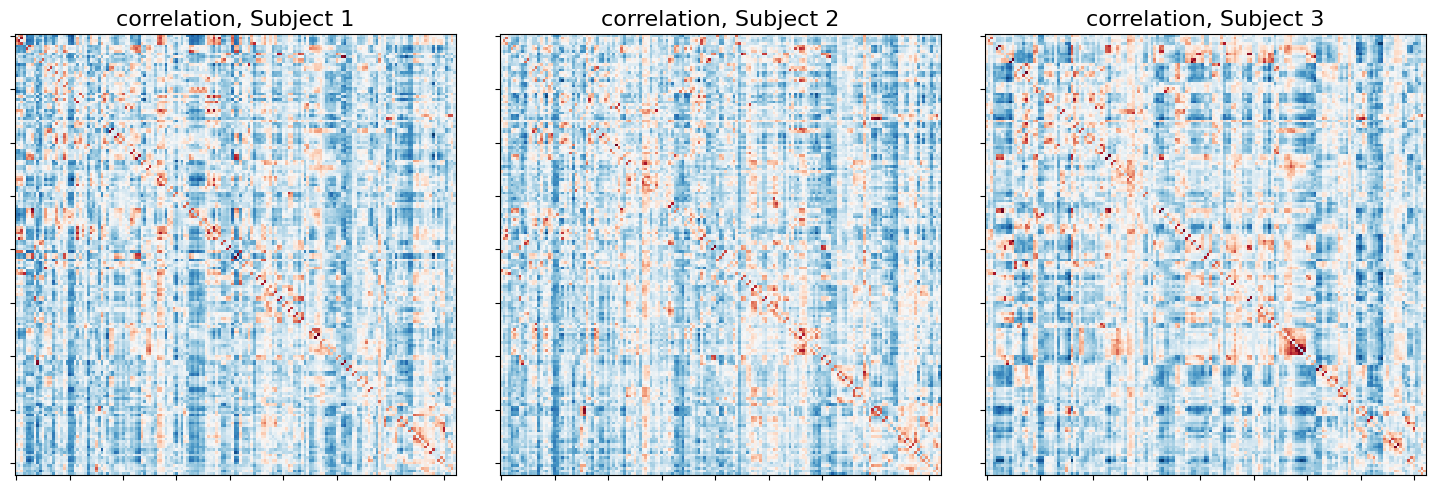

In [35]:
# Display the connectome matrices of the first 3 subjects
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, colorbar=False, axes=ax,
                         title='correlation, Subject {}'.format(i+1))

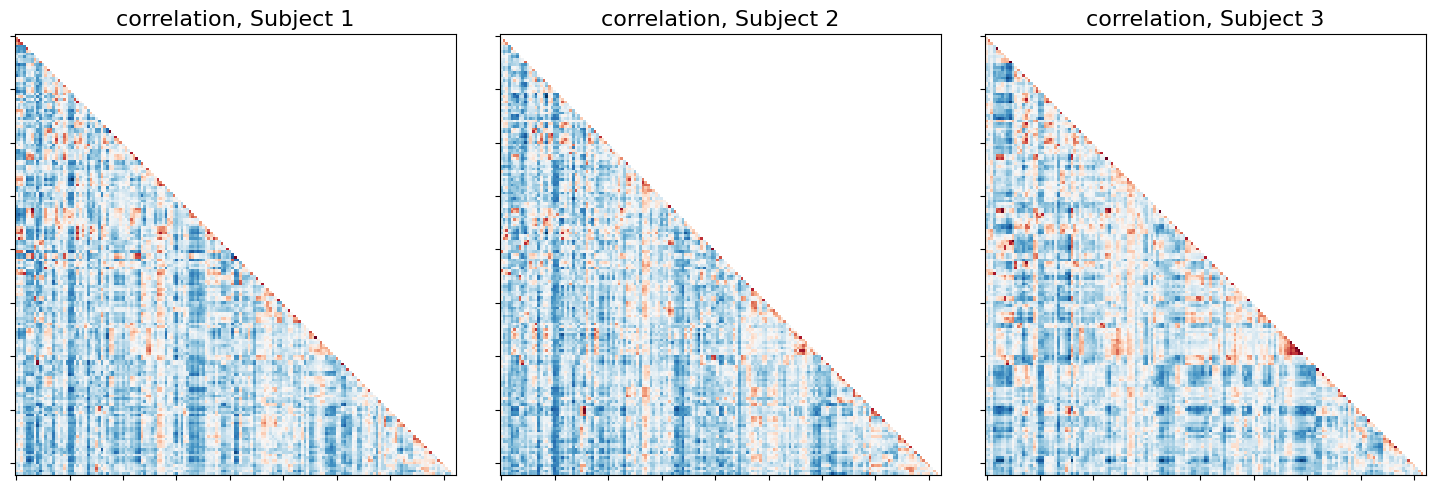

In [36]:
# Display the lower-triangular connectome matrices of the first 3 subjects
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, colorbar=False, axes=ax, tri='lower',
                         title='correlation, Subject {}'.format(i+1))

In [37]:
# Generate mean correlation matrix of all subjects
mean_correlation_matrix = np.mean(correlation_matrices, axis=0)

# Fight numerical instabilities: make symmetric
mean_correlation_matrix += mean_correlation_matrix.T
mean_correlation_matrix *= .5
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (165, 165).


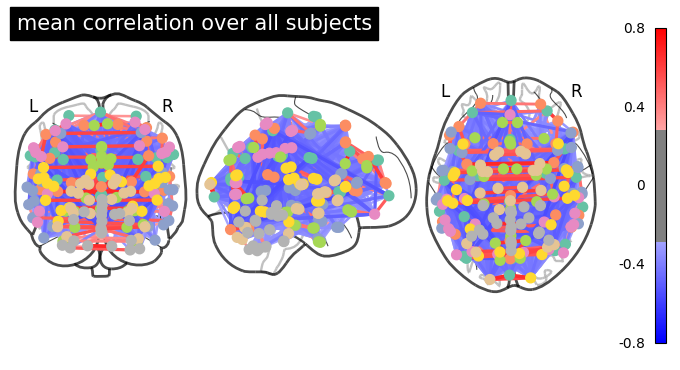

In [38]:
# Display as a connectome the mean correlation matrix over all subjects.
# edge_threshold set because the graph is very dense
plotting.plot_connectome(mean_correlation_matrix, roi_coords,
                         edge_threshold="80%", title='mean correlation over all subjects', colorbar=True)

## SAVE AND EXPORT LABELS

In [52]:
correlation_matrices.shape

(26, 165, 165)

In [53]:
type(gait_scores_df)

pandas.core.frame.DataFrame

In [54]:
DATA_FOLDER = './data_favour/datasets/'
# conn = np.transpose(correlation_matrices, (2, 1, 0))
conn = torch.Tensor(correlation_matrices)
print(f"Connectome (X) shape: {conn.shape}") # n_ROIs, n_ROIs, n_subjects

scores = torch.LongTensor(gait_scores_df["NP3GAIT"])
print(f"Gait scores (y) shape: {scores.shape}") # n_subjects
print(scores)
torch.save(conn, f"{DATA_FOLDER}/connectomes_0.npy")
torch.save(scores, f"{DATA_FOLDER}/scores.npy")

Connectome (X) shape: torch.Size([26, 165, 165])
Gait scores (y) shape: torch.Size([26])
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0])


In [55]:
merged_df_multi = pd.DataFrame(list(zip(correlation_matrices, scores, gait_scores_df["PATNO"])),
               columns =['corr', 'labels', 'p_ids'])
records_multi = merged_df_multi.to_records(index=False)
data_multi = np.array(records_multi, dtype=records_multi.dtype.descr)

np.save(f"{DATA_FOLDER}/ppmi_multi.npy", data_multi)

In [44]:
gait_scores_bin = []
for score in scores:
    if score < 2:
        gait_scores_bin.append(0)
    else:
        gait_scores_bin.append(1)

print(gait_scores_bin)
merged_df_bin = pd.DataFrame(list(zip(correlation_matrices, gait_scores_bin, subject_ids)),columns =['corr', 'labels', 'p_ids'])

merged_df['labels'] = merged_df['labels'].map({0:0, 1:0, 2:1, 3:1})
print(merged_df)

records_bin = merged_df_bin.to_records(index=False)
data = np.array(records_bin, dtype = records_bin.dtype.descr)

np.save(f"{DATA_FOLDER}/sudall_binary.npy", data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


NameError: name 'subject_ids' is not defined

In [36]:
tmp = np.load(f"{DATA_FOLDER}/ppmi_multi.npy", allow_pickle=True)

In [37]:
tmp["corr"].shape

(26,)

In [56]:
merged_df_multi

,corr,labels,p_ids
0,"[[-0.12231934845006158, 0.3876380240536462, 0....",tensor(1),3130
1,"[[-0.12231934845006158, 0.0074498138517291035,...",tensor(1),3134
2,"[[-0.12231934845006158, 0.12840514481656184, 0...",tensor(0),3327
3,"[[-0.12231934845006158, -0.17425924783910135, ...",tensor(0),3332
4,"[[-0.12231934845006158, 0.019058198167841905, ...",tensor(0),3383
5,"[[-0.12231934845006158, -0.174654656351512, 0....",tensor(0),3385
6,"[[-0.12231934845006158, 0.21397667414404853, 0...",tensor(0),3386
7,"[[-0.12231934845006158, -0.16240472116876153, ...",tensor(0),3387
8,"[[-0.12231934845006158, 0.3960591062595621, 0....",tensor(0),3389
9,"[[-0.12231934845006158, -0.06876616361791657, ...",tensor(0),3390
